### Machine Learning Out-of-sample Forecasting

In [1]:
import os
os.getcwd()
# os.chdir(path)    # or you can set your working dir.

'/Users/xingfuxu/PycharmProjects/EquityPremiumPredictionML-Jupyter'

In [2]:
# Your working dir should include "NN_models.py", Perform_CW_test.py" and "Perform_PT_test.py" files.
from Perform_CW_test import CW_test
from Perform_PT_test import PT_test
from NN_models import Net1, Net2, Net3, Net4, Net5

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
import torch
from skorch import NeuralNetRegressor
from tqdm import tqdm
#
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [4]:
# set seed
torch.manual_seed(1)
np.random.seed(1)

# read data
predictor_df = pd.read_excel(open('ml_equity_premium_data.xlsx', 'rb'), sheet_name='result_predictor')
predictor_df.head()

,month,log_equity_premium,equity_premium,DP,DY,EP,SVAR,BM,NTIS,TBL,...,MA_2_9,MA_2_12,MA_3_9,MA_3_12,MOM_1,MOM_2,MOM_3,MOM_6,MOM_9,MOM_12
0,192701,-0.005710,-0.00571,-2.942374,-2.963349,-2.374773,0.00047,0.44371,0.05082,3.23,...,1,1,1,1,0,0,1,1,1,1
1,192702,0.042017,0.04302,-2.979535,-2.932946,-2.430353,0.00029,0.42850,0.05167,3.29,...,1,1,1,1,1,1,1,1,1,1
2,192703,0.004697,0.00472,-2.976535,-2.970053,-2.445079,0.00092,0.46977,0.04636,3.20,...,1,1,1,1,1,1,1,1,1,1
3,192704,0.009940,0.01002,-2.984225,-2.967143,-2.471309,0.00060,0.45675,0.05051,3.39,...,1,1,1,1,1,1,1,1,1,1
4,192705,0.057987,0.05985,-3.025963,-2.975058,-2.531446,0.00039,0.43478,0.05528,3.33,...,1,1,1,1,1,1,1,1,1,1


In [5]:
# remove irrelavent columns
predictor0 = predictor_df.drop(['month', 'equity_premium'], axis=1)
# get all the predictors and set the log equity premium 1-month ahead
predictor = np.concatenate([predictor0['log_equity_premium'][1:].values.reshape(-1, 1),
                            predictor0.iloc[0:(predictor0.shape[0] - 1), 1:]], axis=1)

# number of rows
N = predictor.shape[0]

# number of all columns, including the log equity premium
n_cols = predictor.shape[1]

# Actual one-month ahead log equity premium
actual = predictor[:, [0]]

# Historical average forecasting as benchmark
y_pred_HA = predictor0['log_equity_premium'].values[0:(predictor0.shape[0] - 1), ].cumsum() / np.arange(1, N + 1)
y_pred_HA = y_pred_HA.reshape(-1, 1)

In [6]:
## Out-of-sample: 1957:01-2020:12
in_out_1957 = predictor_df.index[predictor_df['month'] == 195701][0]
actual_1957 = actual[in_out_1957:, ]
y_pred_HA_1957 = y_pred_HA[in_out_1957:, ]
MSFE_HA_1957 = mean_squared_error(y_pred_HA_1957, actual_1957)

# Machine Learning methods used in GKX (2020)
y_pred_OLS_1957, y_pred_PLS_1957, y_pred_PCR_1957,  y_pred_LASSO_1957 = [], [], [], []
y_pred_ENet_1957, y_pred_GBRT_1957, y_pred_RF_1957 = [], [], []
y_pred_NN1_1957, y_pred_NN2_1957, y_pred_NN3_1957, y_pred_NN4_1957, y_pred_NN5_1957 = [], [], [], [], []

## Other commonly used machine learning method
y_pred_Ridge_1957, y_pred_SVR_1957, y_pred_KNR_1957,  y_pred_XGBoost_1957 = [], [], [], []
y_pred_combination_1957 = []

In [7]:
# control the update month of models during out-of-sample period. 
month_index = 1  # We update our models annually, meaning we refresh them in months 1, 13, 25, ...

In [8]:
for t in tqdm(range(in_out_1957, N)):
    #
    X_train_all = predictor[:t, 1:n_cols]
    y_train_all = predictor[:t, 0]
    # set 15% of all the train data as validation set
    X_train = X_train_all[0:int(len(X_train_all) * 0.85), :]
    X_validation = X_train_all[int(len(X_train_all) * 0.85):t, :]
    y_train = y_train_all[0:int(len(X_train_all) * 0.85)]
    y_validation = y_train_all[int(len(X_train_all) * 0.85):t]
    #
    if month_index % 12 == 1:
        month_index += 1
        # OLS
        OLS = LinearRegression()
        OLS.fit(X_train_all, y_train_all)
        y_pred_OLS_1957.append(OLS.predict(predictor[[t], 1:n_cols])[0])

        # PLS
        PLS_param = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8]}
        PLS_result = {}
        for param in ParameterGrid(PLS_param):
            PLS = PLSRegression(**param)
            PLS.fit(X_train, y_train)
            mse = mean_squared_error(PLS.predict(X_validation), y_validation)
            PLS_result[str(param)] = mse

        PLS_best_param = eval(min(PLS_result, key=PLS_result.get))
        PLS_model = PLSRegression(**PLS_best_param)
        PLS_model.fit(X_train_all, y_train_all)
        y_pred_PLS_1957.append(PLS_model.predict(predictor[[t], 1:n_cols])[0][0])

        # PCR
        PCR_param = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8]}
        PCR_result = {}
        for param in ParameterGrid(PCR_param):
            pca = PCA(**param)
            pca.fit(X_train)
            comps = pca.transform(X_train)
            forecast = LinearRegression()
            forecast.fit(comps, y_train)
            mse = mean_squared_error(forecast.predict(pca.transform(X_validation)), y_validation)
            PCR_result[str(param)] = mse
        #
        PCR_best_param = eval(min(PCR_result, key=PCR_result.get))
        #
        PCR_model = PCA(**PCR_best_param)
        PCR_model.fit(X_train_all)
        PCR_comps = PCR_model.transform(X_train_all)
        PCR_forecast = LinearRegression()
        PCR_forecast.fit(PCR_comps, y_train_all)
        y_pred_PCR_1957.append(PCR_forecast.predict(PCR_model.transform(predictor[[t], 1:n_cols]))[0])

        # LASSO
        LASSO_param = {'alpha': list(10 ** np.arange(-4, 1 + 0.001, 0.2))}
        LASSO_result = {}
        for param in ParameterGrid(LASSO_param):
            LASSO = Lasso(**param)
            LASSO.fit(X_train, y_train)
            mse = mean_squared_error(LASSO.predict(X_validation), y_validation)
            LASSO_result[str(param)] = mse
        #
        LASSO_best_param = eval(min(LASSO_result, key=LASSO_result.get))
        #
        LASSO_model = Lasso(**LASSO_best_param)
        LASSO_model.fit(X_train_all, y_train_all)
        y_pred_LASSO_1957.append(LASSO_model.predict(predictor[[t], 1:n_cols])[0])

        # ENet
        ENet_param = {'alpha': list(10 ** np.arange(-4, 1 + 0.001, 0.2)),
                      'l1_ratio': list(np.arange(0.2, 1, 0.3))}
        ENet_result = {}
        for param in ParameterGrid(ENet_param):
            ENet = ElasticNet(**param)
            ENet.fit(X_train, y_train)
            mse = mean_squared_error(ENet.predict(X_validation), y_validation)
            ENet_result[str(param)] = mse

        ENet_best_param = eval(min(ENet_result, key=ENet_result.get))
        ENet_model = ElasticNet(**ENet_best_param)
        ENet_model.fit(X_train_all, y_train_all)
        y_pred_ENet_1957.append(ENet_model.predict(predictor[[t], 1:n_cols])[0])

        # GBRT
        GBRT_param = {'n_estimators': [10, 50, 100, 150, 200],
                      'max_depth': [2, 3, 4],
                      'min_samples_leaf': [1, 3, 5]}
        GBRT_result = {}
        for param in ParameterGrid(GBRT_param):
            GBRT = GradientBoostingRegressor(**param)
            GBRT.fit(X_train, y_train)
            mse = mean_squared_error(GBRT.predict(X_validation), y_validation)
            GBRT_result[str(param)] = mse

        GBRT_best_param = eval(min(GBRT_result, key=GBRT_result.get))
        GBRT_model = GradientBoostingRegressor(**GBRT_best_param)
        GBRT_model.fit(X_train_all, y_train_all)
        y_pred_GBRT_1957.append(GBRT_model.predict(predictor[[t], 1:n_cols])[0])

        # RF
        RF_param = {'n_estimators': [10, 50, 100, 150, 200],
                    'max_depth': [2, 3, 4],
                    'min_samples_leaf': [1, 3, 5]}
        RF_result = {}
        for param in ParameterGrid(RF_param):
            RF = RandomForestRegressor(**param)
            RF.fit(X_train, y_train)
            mse = mean_squared_error(RF.predict(X_validation), y_validation)
            RF_result[str(param)] = mse

        RF_best_param = eval(min(RF_result, key=RF_result.get))
        RF_model = RandomForestRegressor(**RF_best_param)
        RF_model.fit(X_train_all, y_train_all)
        y_pred_RF_1957.append(RF_model.predict(predictor[[t], 1:n_cols])[0])

        # Neural Network Models: NN1~NN5
        X_train_all_tensor = torch.tensor(X_train_all, dtype=torch.float)
        y_train_all_tensor = torch.tensor(y_train_all.reshape(-1, 1), dtype=torch.float)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float)
        X_validation_tensor = torch.tensor(X_validation, dtype=torch.float)
        y_validation_tensor = torch.tensor(y_validation.reshape(-1, 1), dtype=torch.float)

        # NN1
        NN1_result = {}
        NN1_architecture = {"module__n_feature": X_train_tensor.shape[1],  # n_feature should be the number of predictors
                            "module__n_hidden1": 32,
                            "module__n_output": 1}
        NN1_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                    'lr': [0.001, 0.01],
                    'optimizer__weight_decay': [0.1, 0.01, 0.001]}
        for param in ParameterGrid(NN1_param):
            NN1 = NeuralNetRegressor(Net1, verbose=0, max_epochs=200,
                                     optimizer=torch.optim.SGD,
                                     **NN1_architecture, **param)
            NN1.fit(X_train_tensor, y_train_tensor)
            mse = mean_squared_error(NN1.predict(X_validation_tensor), y_validation)
            NN1_result[str(param)] = mse

        #
        NN1_best_param = eval(min(NN1_result, key=NN1_result.get))
        NN1_model = NeuralNetRegressor(Net1, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                       **NN1_architecture, **NN1_best_param)
        NN1_model.fit(X_train_all_tensor, y_train_all_tensor)
        y_pred_NN1_1957.append(NN1_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])


        # NN2
        NN2_result = {}
        NN2_architecture = {"module__n_feature": X_train_tensor.shape[1],
                            "module__n_hidden1": 32, "module__n_hidden2": 16,
                            "module__n_output": 1}
        NN2_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                    'lr': [0.001, 0.01],
                    'optimizer__weight_decay': [0.1, 0.01, 0.001]}
        for param in ParameterGrid(NN2_param):
            NN2 = NeuralNetRegressor(Net2, verbose=0, max_epochs=200,
                                     optimizer=torch.optim.SGD,
                                     **NN2_architecture, **param)
            NN2.fit(X_train_tensor, y_train_tensor)
            mse = mean_squared_error(NN2.predict(X_validation_tensor), y_validation)
            NN2_result[str(param)] = mse
        
        #
        NN2_best_param = eval(min(NN2_result, key=NN2_result.get))
        NN2_model = NeuralNetRegressor(Net2, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                       **NN2_architecture, **NN2_best_param)
        NN2_model.fit(X_train_all_tensor, y_train_all_tensor)
        y_pred_NN2_1957.append(NN2_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        #

        # NN3
        NN3_result = {}
        NN3_architecture = {"module__n_feature": X_train_tensor.shape[1],
                            # n_feature should be the number of predictors
                            "module__n_hidden1": 32, "module__n_hidden2": 16,
                            "module__n_hidden3": 8,
                            "module__n_output": 1}
        NN3_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                     'lr': [0.001, 0.01],
                     'optimizer__weight_decay': [0.1, 0.01, 0.001]}
        for param in ParameterGrid(NN3_param):
            NN3 = NeuralNetRegressor(Net3, verbose=0, max_epochs=200,
                                     optimizer=torch.optim.SGD,
                                     **NN3_architecture, **param)
            NN3.fit(X_train_tensor, y_train_tensor)
            mse = mean_squared_error(NN3.predict(X_validation_tensor), y_validation)
            NN3_result[str(param)] = mse

        #
        NN3_best_param = eval(min(NN3_result, key=NN3_result.get))
        NN3_model = NeuralNetRegressor(Net3, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                       **NN3_architecture, **NN3_best_param)
        NN3_model.fit(X_train_all_tensor, y_train_all_tensor)
        y_pred_NN3_1957.append(NN3_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        #

        # NN4
        NN4_result = {}
        NN4_architecture = {"module__n_feature": X_train_tensor.shape[1],
                            "module__n_hidden1": 32, "module__n_hidden2": 16,
                            "module__n_hidden3": 8,  "module__n_hidden4": 4,
                            "module__n_output": 1}
        NN4_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                     'lr': [0.001, 0.01],
                     'optimizer__weight_decay': [0.1, 0.01, 0.001]}
        for param in ParameterGrid(NN4_param):
            NN4 = NeuralNetRegressor(Net4, verbose=0, max_epochs=200,
                                     optimizer=torch.optim.SGD,
                                     **NN4_architecture, **param)
            NN4.fit(X_train_tensor, y_train_tensor)
            mse = mean_squared_error(NN4.predict(X_validation_tensor), y_validation)
            NN4_result[str(param)] = mse

        #
        NN4_best_param = eval(min(NN4_result, key=NN4_result.get))
        NN4_model = NeuralNetRegressor(Net4, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                       **NN4_architecture, **NN4_best_param)
        NN4_model.fit(X_train_all_tensor, y_train_all_tensor)
        y_pred_NN4_1957.append(NN4_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        #

        # NN5
        NN5_result = {}
        NN5_architecture = {"module__n_feature": X_train_tensor.shape[1],
                            "module__n_hidden1": 32, "module__n_hidden2": 16,
                            "module__n_hidden3": 8,  "module__n_hidden4": 4,
                            "module__n_hidden5": 2,
                            "module__n_output": 1}
        NN5_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                     'lr': [0.001, 0.01],
                     'optimizer__weight_decay': [0.1, 0.01, 0.001]}
        for param in ParameterGrid(NN5_param):
            NN5 = NeuralNetRegressor(Net5, verbose=0, max_epochs=200,
                                     optimizer=torch.optim.SGD,
                                     **NN5_architecture, **param)
            NN5.fit(X_train_tensor, y_train_tensor)
            mse = mean_squared_error(NN5.predict(X_validation_tensor), y_validation)
            NN5_result[str(param)] = mse

        #
        NN5_best_param = eval(min(NN5_result, key=NN5_result.get))
        NN5_model = NeuralNetRegressor(Net5, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                       **NN5_architecture, **NN5_best_param)
        NN5_model.fit(X_train_all_tensor, y_train_all_tensor)
        y_pred_NN5_1957.append(NN5_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        #

        ## Other commmonly used ML methods
        # Ridge
        Ridge_param = {'alpha': list(10 ** np.arange(0, 20 + 0.001, 1))}
        Ridge_result = {}
        for param in ParameterGrid(Ridge_param):
            RIDGE = Ridge(**param)
            RIDGE.fit(X_train, y_train)
            mse = mean_squared_error(RIDGE.predict(X_validation), y_validation)
            Ridge_result[str(param)] = mse
        #
        Ridge_best_param = eval(min(Ridge_result, key=Ridge_result.get))
        Ridge_model = Ridge(**Ridge_best_param)
        Ridge_model.fit(X_train_all, y_train_all)
        y_pred_Ridge_1957.append(Ridge_model.predict(predictor[[t], 1:n_cols])[0])

        # SVR
        SVR_param = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4], 'C': [0.1, 0.5, 1]}
        SVR_result = {}
        for param in ParameterGrid(SVR_param):
            SVR_tmp = SVR(**param)
            SVR_tmp.fit(X_train, y_train)
            mse = mean_squared_error(SVR_tmp.predict(X_validation), y_validation)
            SVR_result[str(param)] = mse
        SVR_best_param = eval(min(SVR_result, key=SVR_result.get))
        SVR_model = SVR(**SVR_best_param)
        SVR_model.fit(X_train_all, y_train_all)
        y_pred_SVR_1957.append(SVR_model.predict(predictor[[t], 1:n_cols])[0])

        # KNR
        KNR = KNeighborsRegressor()
        KNR_param = {'n_neighbors': [3, 4, 5, 6, 7], 'weights': ['distance', 'uniform'],
                     'leaf_size': [20, 30, 40], 'p': [1, 2, 3]}
        KNR_result = {}
        for param in ParameterGrid(KNR_param):
            KNR = KNeighborsRegressor(**param)
            KNR.fit(X_train, y_train)
            mse = mean_squared_error(KNR.predict(X_validation), y_validation)
            KNR_result[str(param)] = mse

        KNR_best_param = eval(min(KNR_result, key=KNR_result.get))
        KNR_model = KNeighborsRegressor(**KNR_best_param)
        KNR_model.fit(X_train_all, y_train_all)
        y_pred_KNR_1957.append(KNR_model.predict(predictor[[t], 1:n_cols])[0])


        # XGBoost
        XGBoost_param =  {'max_depth': [4, 5, 6, 7, 8], 'eta': [0.01, 0.1],
                          'lambda': [0, 0.5, 1], 'alpha': [0, 0.5, 1]}
        XGBoost_result = {}
        for param in ParameterGrid(XGBoost_param):
            XGBoost = XGBRegressor(**param)
            XGBoost.fit(X_train, y_train)
            mse = mean_squared_error(XGBoost.predict(X_validation), y_validation)
            XGBoost_result[str(param)] = mse

        XGB_best_param = eval(min(XGBoost_result, key=XGBoost_result.get))
        XGB_model = XGBRegressor(**XGB_best_param)
        XGB_model.fit(X_train_all, y_train_all)
        y_pred_XGBoost_1957.append(XGB_model.predict(predictor[[t], 1:n_cols])[0])
    else:
        month_index += 1
        y_pred_OLS_1957.append(OLS.predict(predictor[[t], 1:n_cols])[0])
        y_pred_PLS_1957.append(PLS_model.predict(predictor[[t], 1:n_cols])[0][0])
        y_pred_PCR_1957.append(PCR_forecast.predict(PCR_model.transform(predictor[[t], 1:n_cols]))[0])
        y_pred_LASSO_1957.append(LASSO_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_ENet_1957.append(ENet_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_GBRT_1957.append(GBRT_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_RF_1957.append(RF_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_NN1_1957.append(NN1_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        y_pred_NN2_1957.append(NN2_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        y_pred_NN3_1957.append(NN3_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        y_pred_NN4_1957.append(NN4_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        y_pred_NN5_1957.append(NN5_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
        # Other commonly used ML methods
        y_pred_Ridge_1957.append(Ridge_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_SVR_1957.append(SVR_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_KNR_1957.append(KNR_model.predict(predictor[[t], 1:n_cols])[0])
        y_pred_XGBoost_1957.append(XGB_model.predict(predictor[[t], 1:n_cols])[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 767/767 [5:26:15<00:00, 25.52s/it]


In [9]:
y_ml_pred = pd.DataFrame(np.array([y_pred_OLS_1957, y_pred_PLS_1957, y_pred_PCR_1957, y_pred_LASSO_1957,
                                   y_pred_ENet_1957, y_pred_GBRT_1957, y_pred_RF_1957, y_pred_NN1_1957,
                                   y_pred_NN2_1957, y_pred_NN3_1957, y_pred_NN4_1957, y_pred_NN5_1957,
                                   y_pred_Ridge_1957, y_pred_SVR_1957, y_pred_KNR_1957, y_pred_XGBoost_1957]),
                         index=['OLS', 'PLS', 'PCR', 'LASSO', 'ENet', 'GBRT', 'RF', 'NN1',
                                'NN2', 'NN3', 'NN4', 'NN5', 'Ridge', 'SVR', 'KNR', 'XGBoost'],
                         columns=predictor_df.month[in_out_1957:N]).T
y_ml_pred['Combined'] = y_ml_pred.mean(axis=1)
with pd.ExcelWriter("ml_equity_premium_results.xlsx") as writer:
    y_ml_pred.to_excel(writer, sheet_name='ml_pred_equity_premium')
y_ml_pred.head()

,OLS,PLS,PCR,LASSO,ENet,GBRT,RF,NN1,NN2,NN3,NN4,NN5,Ridge,SVR,KNR,XGBoost,Combined
month,,,,,,,,,,,,,,,,,
195701,0.004428,-0.016667,0.007213,0.006473,0.006473,0.008684,0.012229,-0.002745,0.009742,-0.047933,0.014956,0.010947,0.006473,0.054515,0.017691,0.012277,0.006547
195702,0.005713,-0.016443,0.007902,0.006473,0.006473,0.008684,0.011415,0.015875,0.007462,-0.066856,0.014183,0.010947,0.006473,-0.020409,-0.002112,-0.006975,-0.000700
195703,0.000727,-0.014750,0.008082,0.006473,0.006473,0.008684,0.011415,0.010402,0.006566,-0.070792,0.014089,0.010947,0.006473,-0.026256,0.014704,0.007573,0.000051
195704,-0.007605,-0.008439,0.009294,0.006473,0.006473,0.008684,0.010827,-0.008792,0.003735,-0.054427,0.014083,0.010947,0.006473,-0.012564,0.003890,0.000429,-0.000657
195705,-0.002662,0.003668,0.009749,0.006473,0.006473,0.010542,0.012229,0.009576,0.005440,-0.032416,0.014338,0.010947,0.006473,-0.025385,0.000861,0.004927,0.002577


In [10]:
# Performance compared with HA benchmark
# y_ml_pred = pd.read_excel(open("ml_equity_premium_results.xlsx", 'rb'), sheet_name='ml_pred_equity_premium', index_col=[0])

def compute_oos_r_square(actual, y_benchmark, y_pred):
    MSFE_benchmark = mean_squared_error(y_benchmark, actual)
    MSFE_pred = mean_squared_error(y_pred, actual)
    return 1 - MSFE_pred / MSFE_benchmark


ml_oos_performance = []

for col in y_ml_pred.columns:
    oos_r_square = compute_oos_r_square(actual_1957, y_pred_HA_1957, y_ml_pred[[col]].to_numpy())
    MSFE_adjusted, pvalue_MSFE = CW_test(actual_1957, y_pred_HA_1957, y_ml_pred[[col]].to_numpy())
    success_ratio, PT_stat, pvalue_PT = PT_test(actual_1957, y_ml_pred[[col]].to_numpy())
    ml_oos_performance.append([oos_r_square * 100, MSFE_adjusted, pvalue_MSFE, success_ratio * 100, PT_stat, pvalue_PT])


ml_oos_performance_df = pd.DataFrame(np.array(ml_oos_performance),
                                     index=y_ml_pred.columns,
                                     columns=['oos_r_square', 'MSFE_adjusted', 'pvalue_MSFE',
                                              'success_ratio', 'PT_stat', 'pvalue_PT'])
# success ratio of HA
success_ratio_HA_1957, PT_HA_1957, p2_HA_1957 = PT_test(actual_1957, y_pred_HA_1957)
ml_oos_performance_df.loc['HA'] = [0, np.nan, np.nan, success_ratio_HA_1957 * 100, PT_HA_1957, p2_HA_1957]
ml_oos_performance_df

/Users/xingfuxu/PycharmProjects/EquityPremiumPredictionML-Jupyter/Perform_PT_test.py:38: RuntimeWarning: invalid value encountered in double_scalars
  stat = (p_hat - p_star) / np.sqrt(p_hat_var - p_star_var)


,oos_r_square,MSFE_adjusted,pvalue_MSFE,success_ratio,PT_stat,pvalue_PT
OLS,-12.679806,0.613661,0.269720,56.062581,2.200000,0.013903
PLS,-5.188425,0.597302,0.275153,55.541069,1.334480,0.091023
PCR,0.230484,1.840171,0.032872,59.191656,3.016182,0.001280
LASSO,-1.372147,0.798383,0.212324,58.670143,1.879655,0.030078
ENet,-1.415442,0.752462,0.225887,58.539765,2.074104,0.019035
GBRT,-14.454301,1.130489,0.129135,58.018253,0.599788,0.274324
RF,-7.165296,0.132872,0.447147,58.148631,0.763361,0.222624
NN1,-12.878649,-1.371912,0.914955,58.279009,0.923294,0.177927
NN2,-5.021921,-0.284496,0.611985,58.539765,1.167757,0.121452
NN3,-17.330915,1.064000,0.143664,54.498044,-0.493596,0.689204


In [11]:
## Performance during recession and expansion
recession = pd.read_excel(open('ml_equity_premium_data.xlsx', 'rb'), sheet_name='NBER_recession', index_col=[0])
#
y_ml_pred_cycle = y_ml_pred.join(recession, how='left')
#
ml_recession = []
for col in y_ml_pred.columns[:17]:
    recession_index = list(np.where(y_ml_pred_cycle.recession == 1)[0])
    oos_r_square_recession = compute_oos_r_square(actual_1957[recession_index, :], y_pred_HA_1957[recession_index, :], 
                                                  y_ml_pred[[col]].to_numpy()[recession_index, :])
    ml_recession.append(oos_r_square_recession * 100)

# Append HA benchmark, which is 0.
ml_recession.append(0)
# 
ml_oos_performance_df['oos_r_square_recession'] = ml_recession

## Performance during expansion
ml_expansion = []
for col in y_ml_pred.columns[:17]:
    expansion_index = list(np.where(y_ml_pred_cycle.recession == 0)[0])
    oos_r_square_expansion = compute_oos_r_square(actual_1957[expansion_index, :], y_pred_HA_1957[expansion_index, :], 
                                                  y_ml_pred[[col]].to_numpy()[expansion_index, :])
    ml_expansion.append(oos_r_square_expansion * 100)

# Append HA benchmark, which is 0.
ml_expansion.append(0)
ml_oos_performance_df['oos_r_square_expansion'] = ml_expansion
ml_oos_performance_df

,oos_r_square,MSFE_adjusted,pvalue_MSFE,success_ratio,PT_stat,pvalue_PT,oos_r_square_recession,oos_r_square_expansion
OLS,-12.679806,0.613661,0.269720,56.062581,2.200000,0.013903,-21.129690,-9.858636
PLS,-5.188425,0.597302,0.275153,55.541069,1.334480,0.091023,-7.184732,-4.521917
PCR,0.230484,1.840171,0.032872,59.191656,3.016182,0.001280,2.444603,-0.508746
LASSO,-1.372147,0.798383,0.212324,58.670143,1.879655,0.030078,-4.645637,-0.279225
ENet,-1.415442,0.752462,0.225887,58.539765,2.074104,0.019035,-4.384898,-0.424028
GBRT,-14.454301,1.130489,0.129135,58.018253,0.599788,0.274324,-17.623819,-13.396092
RF,-7.165296,0.132872,0.447147,58.148631,0.763361,0.222624,-8.418794,-6.746789
NN1,-12.878649,-1.371912,0.914955,58.279009,0.923294,0.177927,-21.212444,-10.096237
NN2,-5.021921,-0.284496,0.611985,58.539765,1.167757,0.121452,-8.079600,-4.001051
NN3,-17.330915,1.064000,0.143664,54.498044,-0.493596,0.689204,-23.417374,-15.298823


In [12]:
# save
import openpyxl
with pd.ExcelWriter("ml_equity_premium_results.xlsx", engine='openpyxl', mode='a') as writer:
    ml_oos_performance_df.to_excel(writer, sheet_name='ml_oos_performance')

In [13]:
## calculate difference in cumulative mean square error
# select the best 8 ML models based on oos_r_square
selected_ml_models = ['PLS', 'PCR', 'LASSO', 'ENet', 'RF', 'NN2', 'NN4', 'Ridge']

def compute_mse_diff(actual, y_benchmark, y_pred, k):
    MSFE_benchmark = mean_squared_error(y_benchmark[:k], actual[:k])
    MSFE_pred = mean_squared_error(y_pred[:k], actual[:k])
    return MSFE_benchmark - MSFE_pred


ml_diff_in_cumulative_mse = []
for col in selected_ml_models:
    diff_in_cumulative_mse = map(lambda k: compute_mse_diff(actual_1957, y_pred_HA_1957, y_ml_pred[[col]].to_numpy(), k),
                                 range(1, len(actual_1957) + 1))
    ml_diff_in_cumulative_mse.append(list(diff_in_cumulative_mse))

ml_diff_in_cumulative_mse_df = pd.DataFrame(np.array(ml_diff_in_cumulative_mse), index=selected_ml_models,
                                            columns=y_ml_pred.index).T

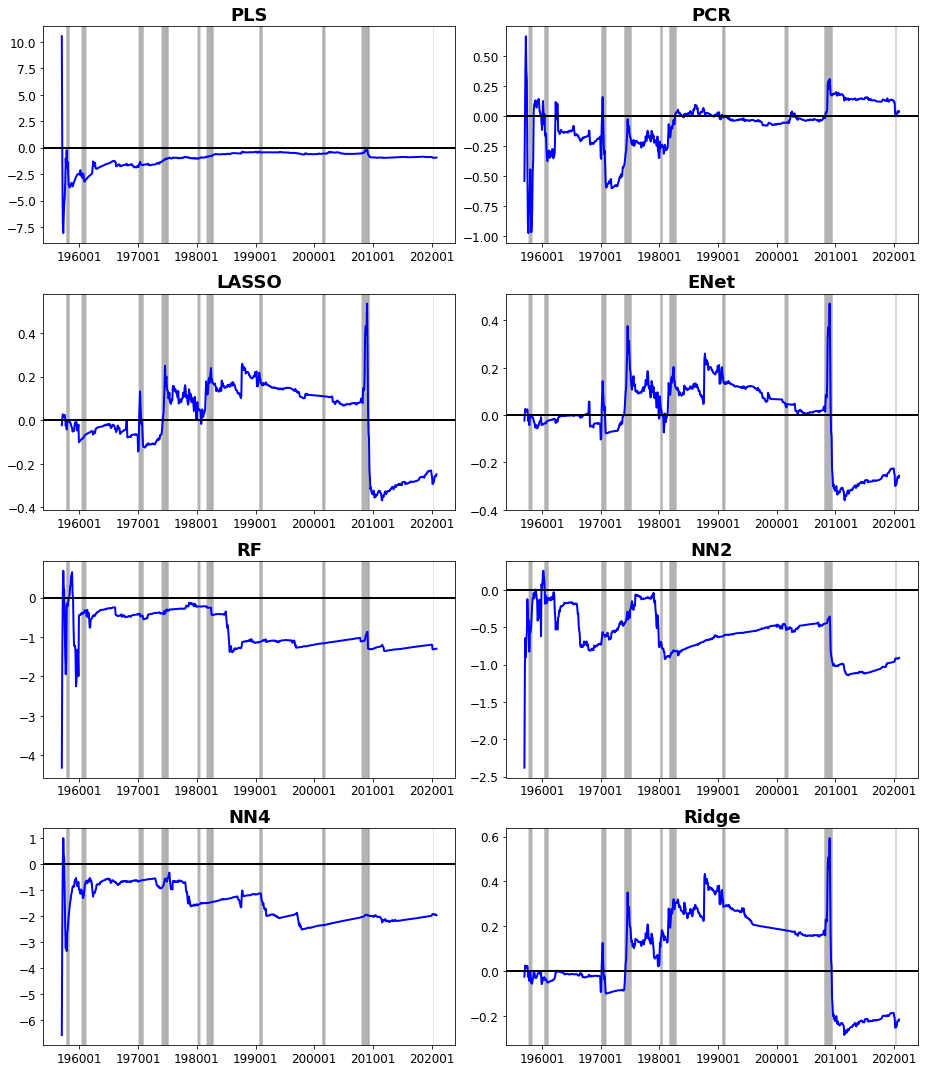

In [14]:
# Display figure
import matplotlib.pyplot as plt
recession_index = np.where(y_ml_pred_cycle.recession == 1)[0]
fig, ax = plt.subplots(int(len(selected_ml_models) / 2), 2, figsize=(13, 15))
for i in range(1, len(selected_ml_models) + 1):
    x = range(len(ml_diff_in_cumulative_mse_df))
    y = ml_diff_in_cumulative_mse_df[selected_ml_models[i - 1]].to_numpy() * 10000
    ax_pos1 = int(i / 2) - 1 if i % 2 == 0 else int(i / 2)
    ax_pos2 = 1 if i % 2 == 0 else 0
    ax[ax_pos1, ax_pos2].plot(x, y, color='blue', linewidth=2)
    ax[ax_pos1, ax_pos2].set_xticks(np.where(ml_diff_in_cumulative_mse_df.index.isin([196001, 197001, 198001, 199001, 200001, 201001, 202001]))[0])
    x_ticklabels = [str(i) for i in [196001, 197001, 198001, 199001, 200001, 201001, 202001]]
    ax[ax_pos1, ax_pos2].set_xticklabels(x_ticklabels)
    ax[ax_pos1, ax_pos2].tick_params(axis='both', which='major', labelsize=12)
    ax[ax_pos1, ax_pos2].axhline(y=0, color='black', linewidth=2)
    ax[ax_pos1, ax_pos2].set_title(label=selected_ml_models[i - 1], fontsize=18, fontweight='bold')
    for j in range(1, len(recession_index)):
        if recession_index[j] - recession_index[j - 1] == 1:
            ax[ax_pos1, ax_pos2].axvspan(recession_index[j - 1], recession_index[j], color='gray', alpha=0.2)

fig.tight_layout()
plt.savefig('Difference_in_cumulative_mse.png')
plt.show()